<a href="https://colab.research.google.com/github/ronitd2002/QROSS-GCN-project/blob/main/trial-notebooks/QROSS_Naive_graph_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# basic libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

### Importing and normalizing the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# upload training data
from google.colab import files

uploaded_1 = files.upload()

In [ ]:
import os

graphs = {}
index = 0

for filename, file_data in uploaded_1.items():
    file_content = file_data.decode('utf-8')

    start_collecting = False
    coordinates = []

    for line in file_content.splitlines():
        if "NODE_COORD_SECTION" in line:
            start_collecting = True
            continue

        if "EOF" in line or line.strip() == '':
            break

        if start_collecting:
            parts = line.split()
            if len(parts) >= 3:
                # Append [x, y] coordinates (ignore the first column)
                coordinates.append([float(parts[1]), float(parts[2])])

    graphs[index] = coordinates
    index += 1

In [ ]:
for graph in graphs:
    print(f"Instance: {graph}\nCoordinates: {graphs[graph]}\n")
    break

Instance: 0
Coordinates: [[190.90116849279775, 590.4280175750611], [166.92708168528983, 530.2271396316246], [1085.991923849472, 16.922422544709608], [481.1400572117718, 1646.5622569153477], [13.17437595135608, 29.384015131643572], [579.5977925840228, 183.09074463391653], [3152.535909779576, 469.4891656526584], [56.79395127865876, 335.7676041800954], [140.16984710530528, 1415.9907047276663], [298.4056652503395, 432.6438567934434], [1329.4159078188572, 398.07979715224917], [184.34432775505695, 310.6223243278328], [1413.9458436791929, 71.70924057019577], [229.8380192520161, 12.507313429062522], [119.85732963663749, 267.10190426680424], [1068.128373699216, 72.16722331618915], [4.4735957948030896, 260.74107597220853], [315.9927811661698, 453.1032177042161], [74.37417532866615, 462.03510416808166], [391.5463212784245, 568.466736501489], [20.04917685531651, 200.4640408371322], [230.93189213865705, 1251.8991123066855], [1572.7308604790571, 269.1672960446028], [592.4233980658983, 398.9286635813

In [ ]:
print(f"Euclidean coordinates of the 35th graph instance are:")
graphs[35]

Euclidean coordinates of the 35th graph instance are:


[[7207.304443622209, 7324.167128487795],
 [4163.142976744452, 433.4999525698357],
 [2490.932722533464, 4875.366088798042],
 [4551.5205625801955, 2982.122152631126],
 [6763.789886532631, 1030.9891543093809],
 [1192.5835434616927, 6609.37024934381],
 [4233.957584681043, 4034.951770206021],
 [2636.353709072561, 6386.539680951245],
 [5349.1546667631965, 9770.2454151319],
 [5350.938714803364, 7417.2756867157395],
 [3603.702035972396, 966.7842507669433],
 [8336.904519630016, 1307.823731512655],
 [2250.7038620979292, 6451.865150099256],
 [9410.524952419511, 6731.366335870505],
 [8976.457769795643, 8503.88983386449],
 [1713.7074001514418, 1096.4539677469254],
 [2822.1366695079887, 5066.67013828053],
 [3449.0565250305203, 9008.22163939093],
 [7599.90158431922, 6101.292179054742],
 [6282.968640320806, 5723.651901213904],
 [5377.336280017825, 658.9912628221895],
 [5782.466661739941, 3623.846327413507],
 [2612.0291245340845, 6706.035485758186],
 [7905.677924103369, 723.4527207413255],
 [8687.76013

In [ ]:
print(f"We have {len(graphs)} graphs each having {len(graphs[0])} [x,y] coordinate points")

We have 85 graphs each having 30 [x,y] coordinate points


In [ ]:
# upload training data
from google.colab import files

uploaded_2 = files.upload()

In [ ]:
import csv
import io

runs = {}
index = 0

for filename, file_data in uploaded_2.items():
    file_content = file_data.decode('utf-8')

    instance_data = []
    csv_reader = csv.reader(io.StringIO(file_content))

    next(csv_reader, None)

    for row in csv_reader:
        relaxation_param = float(row[0])
        p_f = float(row[1])
        e_std = float(row[2])
        e_avg = float(row[3])
        e_min = float(row[4])

        instance_data.append([relaxation_param, p_f, e_std, e_avg, e_min])

    runs[index] = instance_data
    index+=1

In [ ]:
print(f"Now we have all the information. \nThe runs list contains information about {len(runs)} graphs. \nEach of which is tested for {len(runs[0])} different relaxation parameters. \nFor each such parameter we have a vector of length {len(runs[0][0])} information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment")

Now we have all the information. 
The runs list contains information about 85 graphs. 
Each of which is tested for 100 different relaxation parameters. 
For each such parameter we have a vector of length 5 information containing the values of the energies as [A, p_f, e_std, e_avg, e_min] extracted from the annealing experiment


`data[i][j] = [relaxation_parameter, p_f, e_std, e_avg, e_min]` for the $j^{th}$ run of the $i^{th}$ instance

In [ ]:
runs[0][0]

[1952.0, 0.046875, 19742.68658959116, 1589.5882639783756, 16002.903095621281]

## Normalization

Now the instance coordinates are all normalized as per the formula $x^j_i (norm) = (x^j_i - \mu^j)/ \sigma^j$ where $i$ denotes the $i^{th}$ coordinate and $j$ denotes the $j^{th}$ graph instance indexed from 0 -> 84.

In [ ]:
import numpy as np

normed_graphs = {}

for index, coordinates in graphs.items():
    if isinstance(coordinates, list) and all(isinstance(coord, list) and len(coord) == 2 for coord in coordinates):
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        mean_x = np.mean(x_coords)
        stddev_x = np.std(x_coords)
        mean_y = np.mean(y_coords)
        stddev_y = np.std(y_coords)

        # Normalize formula
        normalized_coords = [
            [(x - mean_x) / stddev_x, (y - mean_y) / stddev_y] for x, y in coordinates
        ]

        normed_graphs[index] = normalized_coords
    else:
        print(f"Skipping instance {filename}: Invalid data format")

In [ ]:
ith_run= np.random.randint(100)
ith_run

39

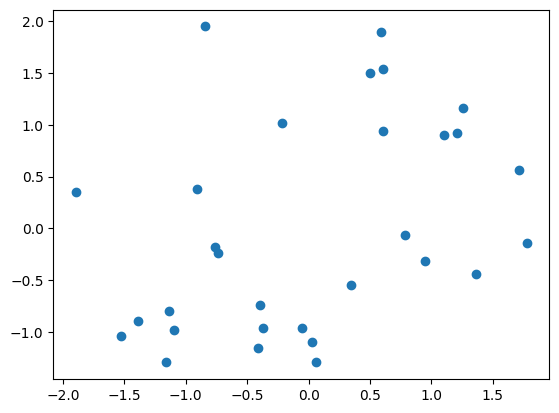

In [ ]:
x = [coord[0] for coord in normed_graphs[ith_run]]
y = [coord[1] for coord in normed_graphs[ith_run]]
plt.scatter(x,y)
plt.show()

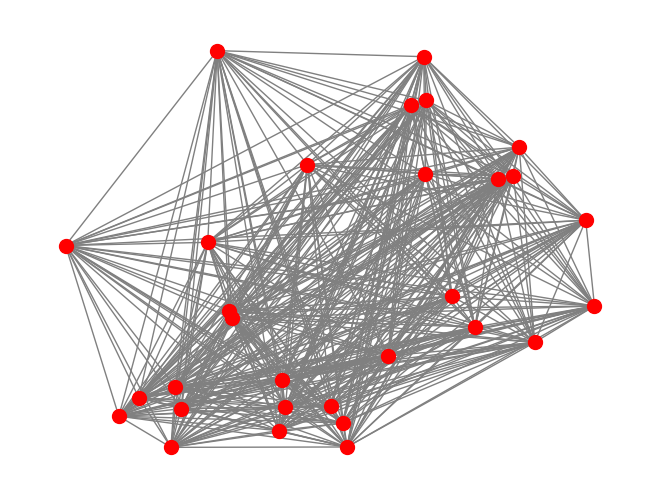

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
positions = {i: (x[i], y[i]) for i in range(len(x))}
G.add_nodes_from(positions.keys())
edges = [(i, j) for i in range(len(x)) for j in range(i + 1, len(x))]
G.add_edges_from(edges)
#plt.figure(figsize=(4, 4))
nx.draw(G, pos=positions, node_color='red', node_size=100, edge_color='gray')
plt.show()

In [ ]:
for index in normed_graphs:
  normed_graphs[index] = np.array(normed_graphs[index]).flatten()

In [ ]:
len(normed_graphs[0]), normed_graphs[0]

(60,
 array([-0.53957575,  0.4398966 , -0.57636841,  0.28891542,  0.83410605,
        -0.99843048, -0.09415066,  3.08863531, -0.81233028, -0.96717734,
         0.05695089, -0.58168756,  4.00559883,  0.13658722, -0.745388  ,
        -0.19878064, -0.61743232,  2.51037189, -0.37459028,  0.04418079,
         1.20768504, -0.04250437, -0.54963843, -0.2618439 ,  1.33741181,
        -0.86102752, -0.47981997, -1.00950338, -0.64860562, -0.37099122,
         0.80669114, -0.85987892, -0.82568323, -0.3869439 , -0.3475996 ,
         0.09549198, -0.7184079 ,  0.11789276, -0.23164877,  0.38481866,
        -0.80177963, -0.53811608, -0.47814122,  2.09883731,  1.5810967 ,
        -0.36581131,  0.07663415, -0.04037545, -0.41677442, -0.76171185,
         0.60644975,  0.22005312, -0.25071462, -0.31015826, -0.18220782,
         1.05483859, -0.0163723 , -0.94961733, -0.80539512, -0.97596014]))

## Naive Autoencoder

In [ ]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

instance_dict = {'train': [], 'val': []}
dataset_sizes = {'train': 0, 'val': 0}

for i in range(len(normed_graphs)):
  if np.random.rand() < 0.8:
    instance_dict['train'].append(normed_graphs[i])
    dataset_sizes['train'] += 1
  else:
    instance_dict['val'].append(normed_graphs[i])
    dataset_sizes['val'] += 1

class TSPDataset(Dataset):
    def __init__(self, instances):
        self.instances = instances

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        coordinates = torch.tensor(self.instances[idx], dtype=torch.float32)
        return coordinates

datasets = {x: TSPDataset(instance_dict[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}

for instance_data in dataloaders['train']:
    print(instance_data.shape)
    break

torch.Size([16, 60])


In [ ]:
# structure of the autoencoder
class Autoencoder_TSP(nn.Module):
    def __init__(self, bottleneck):
        super(Autoencoder_TSP, self).__init__()

        self.sig = nn.Sigmoid()

        self.enc1 = nn.Linear(60, 45)
        self.enc2 = nn.Linear(45, bottleneck)
        self.dec1 = nn.Linear(bottleneck, 45)
        self.dec2 = nn.Linear(45, 60)

    def forward(self, x):

        x = self.enc1(x)
        x = self.sig(x)
        x = self.enc2(x)
        x = self.sig(x)
        x = self.dec1(x)
        x = self.sig(x)
        x = self.dec2(x)
        x = self.sig(x)
        x = 2*x - 1             # to re-adjust x value to the interval [-1,1]

        return x

### The Training

In [ ]:
import time
from copy import deepcopy
import matplotlib.pyplot as plt

def train(model, criterion, optimizer, scheduler, lambda1 = 0, num_epochs = 25):

  since = time.time()

  best_model_wts = deepcopy(model.state_dict())
  best_loss = 1000

  _loss = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    if (epoch+1) % 10 == 0 or epoch == 0:
      print(f'\nEpoch {epoch+1}/{num_epochs}')
      print('-' * 10)

    # each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()     # set model to training mode
      else:
        model.eval()      # set model to validation mode

      running_loss = 0

      # iterate over data
      for inputs in dataloaders[phase]:
        inputs = inputs.to(device)
        # .to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          output = model(inputs)
          loss = criterion(output, inputs)

          # Regularization if necessary

          # backward + optimize only if training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]

      if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'{phase} Loss: {epoch_loss:.4f}')

      _loss[phase].append(epoch_loss)

      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val loss: {best_loss:.4f}')

  # Load best model weights and return
  model.load_state_dict(best_model_wts)
  return model, _loss

In [ ]:
# using GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
lambda1 = [1e-6]#, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lr = [0.5]#, 0.003, 0.005, 0.005, 0.008, 0.01]
Loss = {'train': [], 'val': []}
bottleneck = 30

for i in range(len(lambda1)):

  print(f"Training with lambda2 = {lambda1[i]}")
  net = Autoencoder_TSP(bottleneck)
  net.to(device)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(net.parameters(), lr = lr[i], momentum = 0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)
  num_epochs = 100

  net, _loss = train(net, criterion, optimizer, scheduler, lambda1[i], num_epochs)

  for phase in ['train', 'val']:
    Loss[phase].append(_loss[phase])

  print('='*20)

Training with lambda2 = 1e-06

Epoch 1/100
----------
train Loss: 0.0714
val Loss: 0.0719

Epoch 10/100
----------
train Loss: 0.0698
val Loss: 0.0724

Epoch 20/100
----------
train Loss: 0.0695
val Loss: 0.0720

Epoch 30/100
----------
train Loss: 0.0695
val Loss: 0.0719

Epoch 40/100
----------
train Loss: 0.0694
val Loss: 0.0722

Epoch 50/100
----------
train Loss: 0.0693
val Loss: 0.0720

Epoch 60/100
----------
train Loss: 0.0693
val Loss: 0.0720

Epoch 70/100
----------
train Loss: 0.0693
val Loss: 0.0720

Epoch 80/100
----------
train Loss: 0.0694
val Loss: 0.0720

Epoch 90/100
----------
train Loss: 0.0694
val Loss: 0.0720

Epoch 100/100
----------
train Loss: 0.0693
val Loss: 0.0720
Training completed in 0m 1s
Best val loss: 0.0716


In [ ]:
train_loss = Loss['train'][0]
val_loss = Loss['val'][0]
train_loss, val_loss

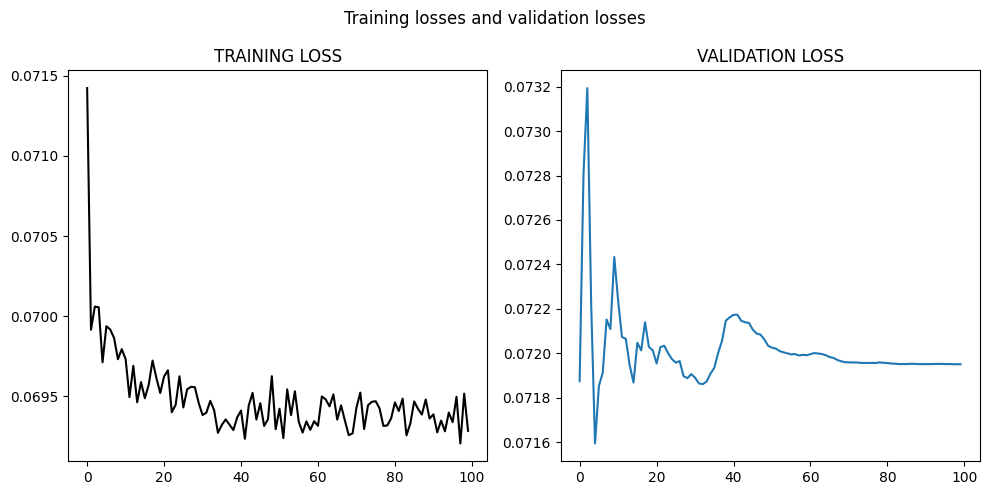

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Training losses and validation losses')

axs[0].set_title("TRAINING LOSS")
axs[0].plot(train_loss, c = "k", ls="-")

axs[1].set_title("VALIDATION LOSS")
axs[1].plot(val_loss, ls="-")

fig.tight_layout()

#### Classical Autoencoder shows terrible performance

# EDA

`data tensor = A[graph_index][data for each relax param]`

`data = [A,pf,estd,eavg,emin]`

In [ ]:
ith_graph = np.random.randint(100)
values = runs[ith_graph]
As = [value[0] for value in values]
pfs = [value[1] for value in values]
estds = [value[2] for value in values]
eavs = [value[3] for value in values]
emins = [value[4] for value in values]
values[1]

[5050.0, 0.046875, 82341.63965932177, 4955.113754135996, 69548.88312910497]

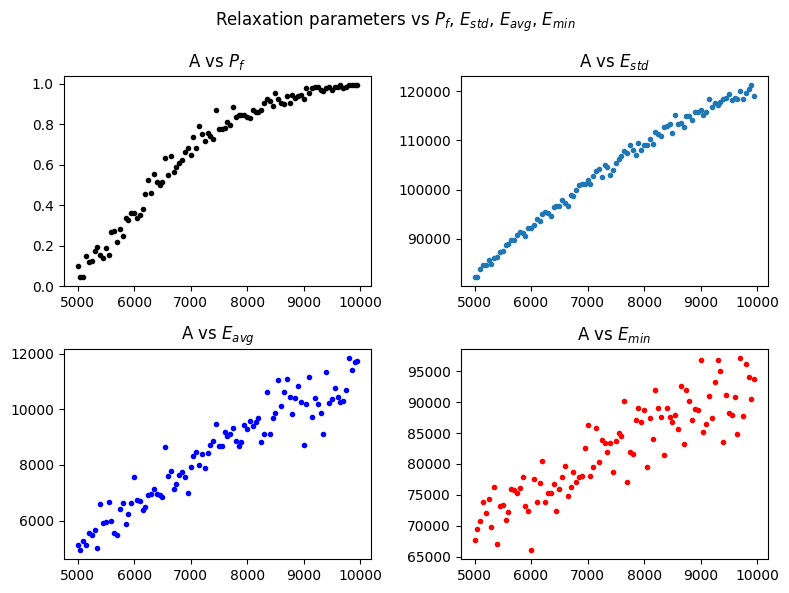

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,6))
fig.suptitle('Relaxation parameters vs $P_f$, $E_{std}$, $E_{avg}$, $E_{min}$')

axs[0, 0].set_title("A vs $P_f$")
axs[0, 0].scatter(As, pfs, marker = ".", c = 'k')

axs[0, 1].set_title("A vs $E_{std}$")
axs[0, 1].scatter(As, estds, marker = ".")

axs[1, 0].set_title("A vs $E_{avg}$")
axs[1, 0].scatter(As, eavs, marker = ".", c ='b')

axs[1, 1].set_title("A vs $E_{min}$")
axs[1, 1].scatter(As, emins, marker = ".", c='r')

fig.tight_layout()
fig.savefig('datavis_qross.png')

# Next steps for the project

Our QROSS-based project addresses optimizing relaxation parameters for TSP instances using QUBO formulations and surrogate models. The key challenges include creating usable feature vectors for the neural network and understanding how the training process aligns these vectors with relaxation parameters.

My Plan:

1. **Feature Vector Extraction**:  Use GCNs or similar methods to process graph inputs and produce fixed-size feature vectors. Still have to figure this out. (currently doing so). Hence we build a sort of **FEATURE EXTRACTOR function/class** for each graph **instance**.
2. **Find the min relaxation parameter**: We then assign relaxation parameters from the **data** where P_f is maximized and energy metrics are minimized for training graphs. For this we make a function called a **Min_relaxation_finder**
3. **Train NN based on these min A and the graph feature vectors as the input**:  We then train the model (input → graph feature vector, output → relaxation parameter) using loss functions with `min_relaxation_parameter` as the marker which will use gradient descent etc to backpropagate and thus train our model.
4. **Predict A from test data set for each instance in the test set**: For the test data, we first put them through the FEATURE EXTRACTOR function/class to get the feature vectors of the test graphs annd then retrieve the predicted relaxation parameter for each graph.
5. **Validation**: Now we have the predicted **A**, then we can put the $i^{th}$ graph's data matrix into the min_relaxation_finder function to find the A_min for the particular instance. Then our validation loss shall be (`predicted_A` - `min_A`$)^2$ which should be ideally very very low.

If we do this soon, then we can proudly say some progress is made. Please tell me where I am wrong sir, or I am thinking the wrong way.

# Graph FEATURE VECTOR EXTRACTOR

In [ ]:
print(f"We have {len(graphs)} graphs which have {len(graphs[0])} nodes each with {len(graphs[0][0])} coordinates.")

We have 85 graphs which have 30 nodes each with 2 coordinates.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

num_graphs = len(graphs)
num_nodes = len(graphs[0])
input_dim = len(graphs[0][0])

In [ ]:
def compute_adjacency(coords):
    num_nodes = coords.shape[0]
    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            adjacency_matrix[i, j] = np.sqrt((coords[i, 0] - coords[j, 0])**2 + (coords[i, 1] - coords[j, 1])**2)
    return adjacency_matrix

In [ ]:
# PyTorch Geometric Dataset Preparation
graph_data_list = []
for i in range(num_graphs):
    coords = graphs[i]
    adjacency_matrix = compute_adjacency(np.array(coords))

    edge_index = np.array(np.nonzero(adjacency_matrix)).astype(np.int64)  # Indices of edges
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]  # Edge weights (Euclidean distances)

    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weight = torch.tensor(edge_weight, dtype=torch.float32)
    node_features = torch.tensor(coords, dtype=torch.float32)

    # Create graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)
    graph_data_list.append(data)

In [ ]:
type(graph_data_list[0])

In [ ]:
print(f"We got graph data list for each {len(graph_data_list)} graphs in the samples we took for experiment of the graph pooling")

We got graph data list for each 85 graphs in the samples we took for experiment of the graph pooling


In [ ]:
class GraphFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphFeatureExtractor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))  # Graph-level pooling
        x = self.fc(x)
        return x

In [ ]:
#initialize the Graph convolutional neural network
hidden_dim = 64 # neurons in hidden layer
output_dim = 128 # dimension of the graph feature vector
model = GraphFeatureExtractor(input_dim, hidden_dim, output_dim) # instantiate the model

graph_tensor = graph_data_list[0]
graph_feature_vector = model(graph_tensor)

In [ ]:
# Batch processing for multiple graphs
from torch_geometric.loader import DataLoader

loader = DataLoader(graph_data_list, batch_size=1, shuffle=True)
batch_graph_features_vector = []
for batch in loader:
    batch_graph_features = model(batch)  # Batch graph-level features
    batch_graph_features_vector.append(batch_graph_features)

In [ ]:
len(batch_graph_features_vector) , type(batch_graph_features_vector[0])

(85, torch.Tensor)

In [ ]:
batch_graph_features_vector[0]

tensor([[ 3.1397e+01, -1.4584e+02, -6.1278e+01, -4.2101e+02, -8.8908e+01,
          1.0748e+02, -2.1880e+02,  2.0941e+02, -5.2329e+02,  4.7933e+02,
          4.0512e+02, -9.3510e+01, -2.2691e+02, -1.8421e+00,  8.8434e+01,
         -3.7490e+02, -3.8025e+02, -2.4463e+02,  6.2994e+02, -1.7686e+02,
         -4.0653e+02, -3.9374e+02, -2.5365e+02,  2.6998e+02,  2.5107e+02,
          5.6610e+02, -5.1530e+01, -2.9377e+02, -2.9916e+02,  7.3252e+01,
          4.2934e+02,  5.2099e+02, -2.2339e+01,  2.3902e+02,  4.4672e+02,
         -2.3468e+02, -3.6074e+02, -5.4445e+02, -5.3695e+01, -6.7126e+02,
          2.6957e+02,  1.1197e+02, -1.3875e+02, -2.5309e+02,  1.2096e+02,
          1.2633e+02,  1.4433e+02,  6.4949e+01,  8.5555e+02, -4.0094e+01,
         -4.6874e+02, -1.2583e+02,  6.2913e-01, -1.3725e+02, -1.4280e+02,
         -7.3020e+02, -1.2044e+02,  5.4420e+01,  2.0096e+02,  3.3849e+01,
         -4.1424e+02,  1.2188e+02,  2.8823e+01, -3.3999e+02, -1.2697e+02,
         -2.9138e+02,  2.1170e+02, -8.

Simple encoding. But the model needs to learn.